In [7]:
import os
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, linregress
import seaborn as sns
from qiskit.visualization import plot_histogram


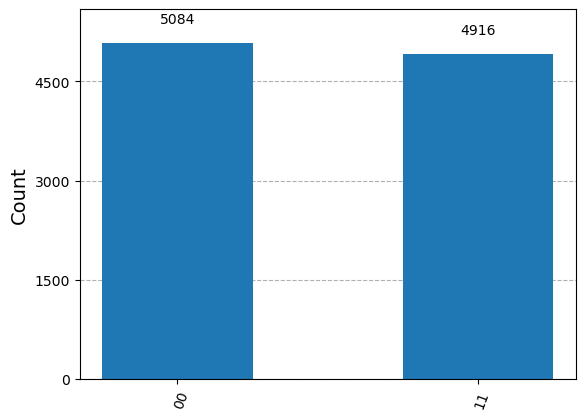

In [9]:
simulator = AerSimulator()

def create_cat_state_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure(range(n), range(n))
    return qc

circuit = create_cat_state_circuit(2)

job = simulator.run(circuit, shots = 10000)
results = job.result()

counts = results.get_counts()

plot_histogram(counts)

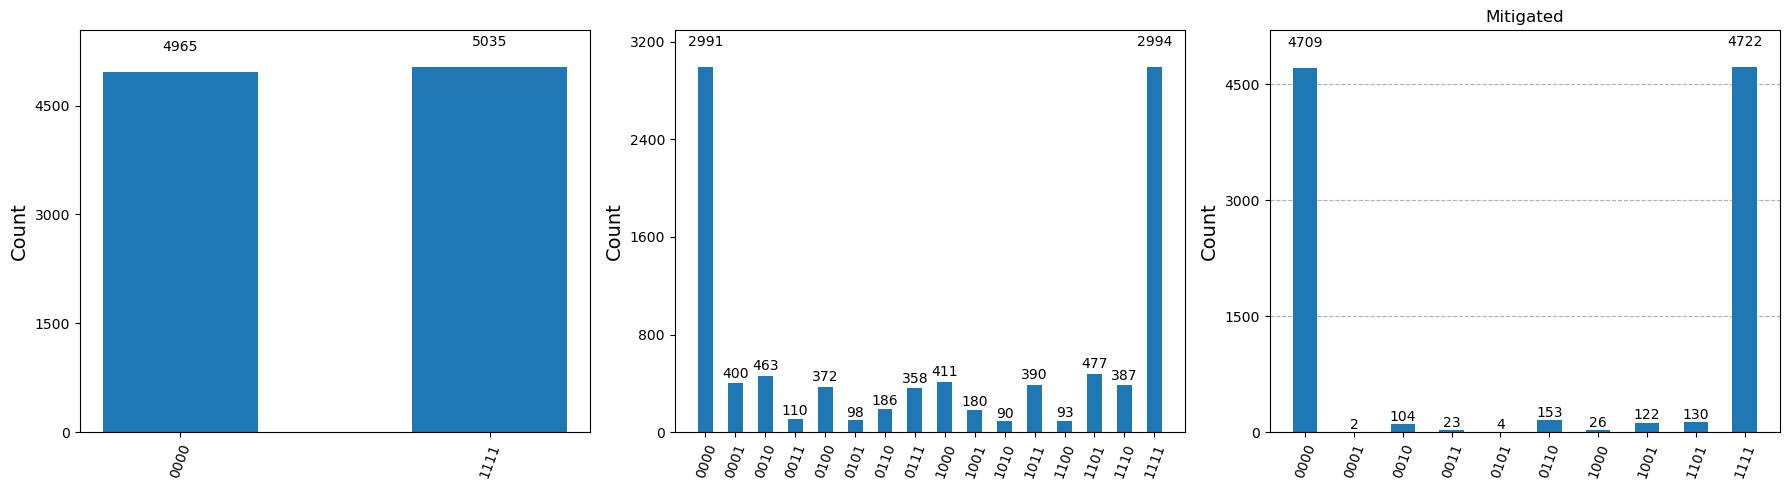

In [15]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
import numpy as np
from scipy.linalg import pinv

# Create the cat state circuit
def create_cat_state_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure(range(n), range(n))
    return qc

# Create noise model
def create_noise_model(p1, p2, n):
    noise_model = NoiseModel()
    
    # Add readout error (SPAM)
    for i in range(n):
        readout_error = ReadoutError([
            [1-p2, p2],    # P(0|0), P(1|0)
            [p2, 1-p2]     # P(0|1), P(1|1)
        ])
        noise_model.add_readout_error(readout_error, [i])
    
    # Add depolarizing error
    h_error = depolarizing_error(p1, 1)
    cx_error = depolarizing_error(p1, 2)
    noise_model.add_all_qubit_quantum_error(h_error, ['h'])
    noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])
    
    return noise_model

# Create mitigation matrix for a cat state
def create_mitigation_matrix(p1, p2, n):
    # Create SPAM error matrix
    def construct_M_spam(p2, n):
        M_single = np.array([[1 - p2, p2], [p2, 1 - p2]])
        result = 1
        for _ in range(n):
            result = np.kron(result, M_single)
        return result
    
    # Create depolarizing error matrix
    def construct_M_depol(p1, n):
        M_single = np.array([[1 - p1/2, p1/2], [p1/2, 1 - p1/2]])
        result = 1
        for _ in range(n):
            result = np.kron(result, M_single)
        return result
    
    M_spam = construct_M_spam(p2, n)
    M_depol = construct_M_depol(p1, n)
    
    # Create mitigation operator
    M_mit = pinv(M_spam) @ pinv(M_depol)
    
    return M_mit

# Apply dampened mitigation
def mitigate_counts(counts, M_mit, n, damping=0.5):
    # Convert counts to probability vector
    P_noisy = np.zeros(2**n)
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        # Convert bitstring to index
        idx = int(bitstring, 2)
        P_noisy[idx] = count / total_shots
    
    # Apply dampened mitigation
    I = np.eye(2**n)
    M_damp = I + damping * (M_mit - I)
    P_mitigated = M_damp @ P_noisy
    
    # Ensure valid probability distribution
    P_mitigated = np.maximum(P_mitigated, 0)
    P_mitigated /= np.sum(P_mitigated)
    
    # Convert back to counts format
    mitigated_counts = {}
    for i in range(2**n):
        if P_mitigated[i] > 0:
            bitstring = format(i, f'0{n}b')
            mitigated_counts[bitstring] = int(P_mitigated[i] * total_shots)
    
    return mitigated_counts

# Run the experiment
def run_experiment(n=2, p1=0.05, p2=0.2, damping=0.9, shots=10000):
    # Create circuit
    circuit = create_cat_state_circuit(n)
    
    # Create noise model and noisy simulator
    noise_model = create_noise_model(p1, p2, n)
    noisy_simulator = AerSimulator(noise_model=noise_model)
    
    # Run noisy simulation
    noisy_job = noisy_simulator.run(circuit, shots=shots)
    noisy_counts = noisy_job.result().get_counts()
    
    # Create mitigation matrix
    M_mit = create_mitigation_matrix(p1, p2, n)
    
    # Apply mitigation
    mitigated_counts = mitigate_counts(noisy_counts, M_mit, n, damping)
    
    # Run ideal simulation for comparison
    ideal_simulator = AerSimulator()
    ideal_job = ideal_simulator.run(circuit, shots=shots)
    ideal_counts = ideal_job.result().get_counts()
    
    return ideal_counts, noisy_counts, mitigated_counts

# Run the experiment
ideal_counts, noisy_counts, mitigated_counts = run_experiment(n=4, p1=0.05, p2=0.1)

# Plot the results
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_histogram(ideal_counts, title="Ideal", ax=axs[0])
plot_histogram(noisy_counts, title="Noisy", ax=axs[1])
plot_histogram(mitigated_counts, title="Mitigated", ax=axs[2])

plt.tight_layout()
plt.show()

True noise parameters: p1=0.05, p2=0.1
Estimated noise parameters: p1=0.0260, p2=0.0834


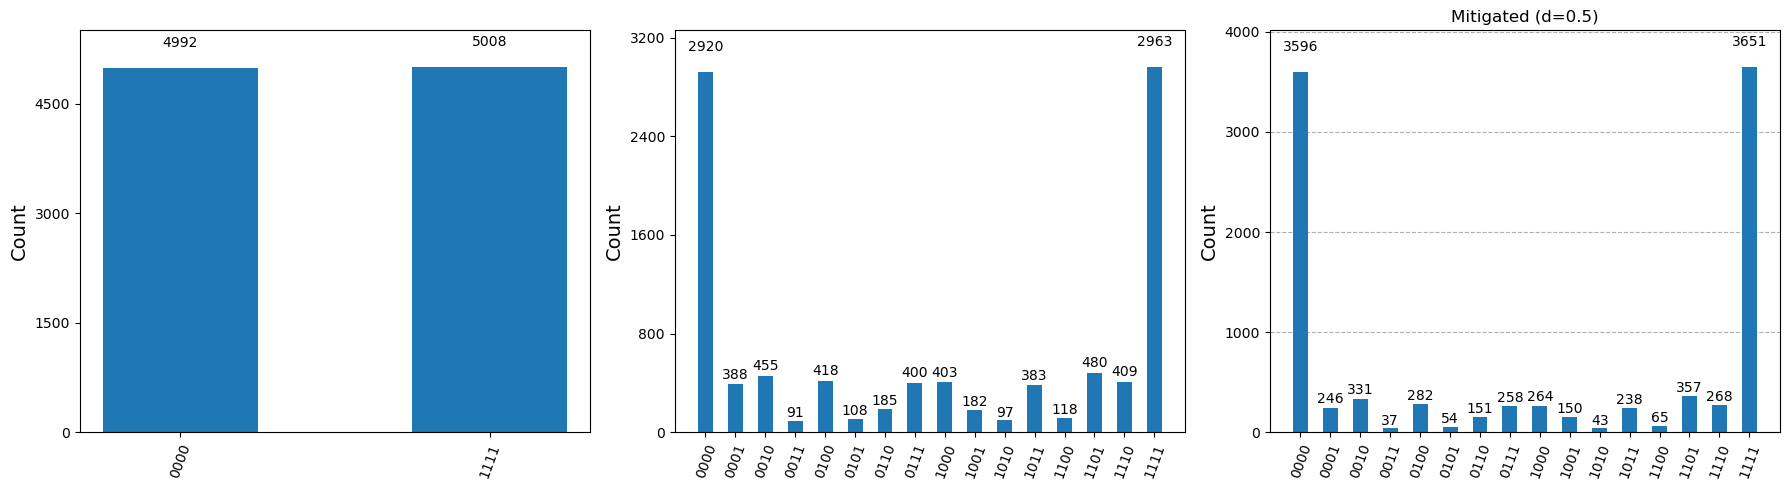

In [30]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
import numpy as np
from scipy.linalg import pinv
import matplotlib.pyplot as plt

# Create the cat state circuit
def create_cat_state_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure(range(n), range(n))
    return qc

# Add noise to the simulator
def create_noisy_simulator(p1, p2, n):
    noise_model = NoiseModel()
    
    # Add readout error (SPAM)
    for i in range(n):
        readout_error = ReadoutError([
            [1-p2, p2],    # P(0|0), P(1|0)
            [p2, 1-p2]     # P(0|1), P(1|1)
        ])
        noise_model.add_readout_error(readout_error, [i])
    
    # Add depolarizing error
    h_error = depolarizing_error(p1, 1)
    cx_error = depolarizing_error(p1, 2)
    noise_model.add_all_qubit_quantum_error(h_error, ['h'])
    noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])
    
    return AerSimulator(noise_model=noise_model)

# Create mitigation matrix based on estimated noise parameters
def create_mitigation_matrix(p1, p2, n):
    # Create SPAM error matrix
    def construct_M_spam(p2, n):
        M_single = np.array([[1 - p2, p2], [p2, 1 - p2]])
        result = 1
        for _ in range(n):
            result = np.kron(result, M_single)
        return result
    
    # Create depolarizing error matrix
    def construct_M_depol(p1, n):
        M_single = np.array([[1 - p1/2, p1/2], [p1/2, 1 - p1/2]])
        result = 1
        for _ in range(n):
            result = np.kron(result, M_single)
        return result
    
    M_spam = construct_M_spam(p2, n)
    M_depol = construct_M_depol(p1, n)
    
    # Create mitigation operator
    M_mit = pinv(M_spam) @ pinv(M_depol)
    
    return M_mit

# Estimate noise parameters from experimental data
def estimate_noise_params(counts, n):
    # Convert counts to probability vector
    P_noisy = np.zeros(2**n)
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        P_noisy[idx] = count / total_shots
    
    # For a cat state, we expect only |00...0⟩ and |11...1⟩
    # Estimate p2 from the presence of strings with one bit flipped
    one_flips = 0
    for bitstring, count in counts.items():
        hamming_weight = sum(int(bit) for bit in bitstring)
        if hamming_weight == 1 or hamming_weight == n-1:
            one_flips += count
    
    # Rough estimate for p2 (SPAM error)
    p2_est = (one_flips / total_shots) / n
    
    # Estimate p1 from additional entropy beyond SPAM
    # This is a simplified approach - in real applications you'd use 
    # more sophisticated methods like those in the original code
    mixed_states = 0
    for bitstring, count in counts.items():
        hamming_weight = sum(int(bit) for bit in bitstring)
        if hamming_weight > 1 and hamming_weight < n-1:
            mixed_states += count
    
    p1_est = (mixed_states / total_shots) / (n-1)
    
    # Constrain to reasonable values
    p1_est = max(min(p1_est, 0.3), 0.001)
    p2_est = max(min(p2_est, 0.3), 0.001)
    
    return p1_est, p2_est

# Apply mitigation to counts
def mitigate_counts(counts, M_mit, n, damping=0.5):
    # Convert counts to probability vector
    P_noisy = np.zeros(2**n)
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        P_noisy[idx] = count / total_shots
    
    # Apply dampened mitigation
    I = np.eye(2**n)
    M_damp = I + damping * (M_mit - I)
    P_mitigated = M_damp @ P_noisy
    
    # Ensure valid probability distribution
    P_mitigated = np.maximum(P_mitigated, 0)
    P_mitigated /= np.sum(P_mitigated)
    
    # Convert back to counts format
    mitigated_counts = {}
    for i in range(2**n):
        if P_mitigated[i] > 0:
            bitstring = format(i, f'0{n}b')
            mitigated_counts[bitstring] = int(P_mitigated[i] * total_shots)
    
    return mitigated_counts

# Run the experiment
def run_experiment(n=2, p1_true=0.05, p2_true=0.1, shots=10000):
    # Create circuit
    circuit = create_cat_state_circuit(n)
    
    # Create noisy simulator and run simulation
    noisy_simulator = create_noisy_simulator(p1_true, p2_true, n)
    noisy_job = noisy_simulator.run(circuit, shots=shots)
    noisy_counts = noisy_job.result().get_counts()
    
    # Estimate noise parameters from the noisy counts
    p1_est, p2_est = estimate_noise_params(noisy_counts, n)
    print(f"True noise parameters: p1={p1_true}, p2={p2_true}")
    print(f"Estimated noise parameters: p1={p1_est:.4f}, p2={p2_est:.4f}")
    
    # Create mitigation matrix using estimated parameters
    M_mit = create_mitigation_matrix(p1_est, p2_est, n)
    
    # Apply mitigation with optimal damping
    damping = 0.5  # Can be optimized further
    mitigated_counts = mitigate_counts(noisy_counts, M_mit, n, damping)
    
    # Run ideal simulation for comparison
    ideal_simulator = AerSimulator()
    ideal_job = ideal_simulator.run(circuit, shots=shots)
    ideal_counts = ideal_job.result().get_counts()
    
    return ideal_counts, noisy_counts, mitigated_counts

# Run and visualize the experiment
ideal_counts, noisy_counts, mitigated_counts = run_experiment(n=4)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_histogram(ideal_counts, title="Ideal", ax=axs[0])
plot_histogram(noisy_counts, title="Noisy", ax=axs[1])
plot_histogram(mitigated_counts, title="Mitigated (d=0.5)", ax=axs[2])

plt.tight_layout()
plt.show()

True noise parameters: p1=0.1, p2=0.5
Estimated noise parameters: p1=0.0686, p2=0.0908
Optimal damping: d=0.01, estimated fidelity=0.0618


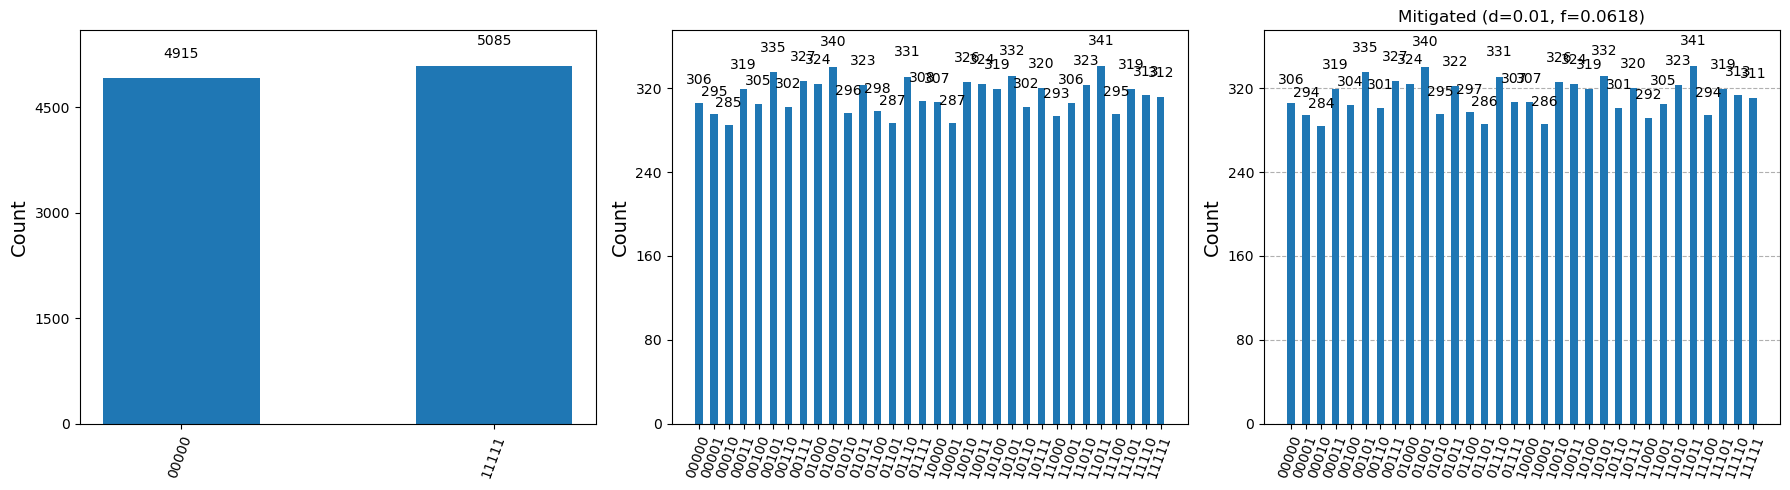

In [55]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
import numpy as np
from scipy.linalg import pinv
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def create_cat_state_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure(range(n), range(n))
    return qc

def create_noisy_simulator(p1, p2, n):
    noise_model = NoiseModel()
    
    # Add readout error (SPAM)
    for i in range(n):
        readout_error = ReadoutError([
            [1-p2, p2],    # P(0|0), P(1|0)
            [p2, 1-p2]     # P(0|1), P(1|1)
        ])
        noise_model.add_readout_error(readout_error, [i])
    
    # Add depolarizing error
    h_error = depolarizing_error(p1, 1)
    cx_error = depolarizing_error(p1, 2)
    noise_model.add_all_qubit_quantum_error(h_error, ['h'])
    noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])
    
    return AerSimulator(noise_model=noise_model)

def calculate_entropy(counts):
    """Calculate Shannon entropy of the distribution"""
    total_shots = sum(counts.values())
    entropy = 0
    for count in counts.values():
        p = count / total_shots
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

def calculate_zero_entropy(counts, n):
    """Calculate entropy of the |0⟩ components"""
    # Create a modified counts dict that groups by Hamming weight
    zero_counts = {}
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        weight = sum(int(bit) for bit in bitstring)
        if weight in zero_counts:
            zero_counts[weight] += count
        else:
            zero_counts[weight] = count
    
    # Calculate entropy of this coarse-grained distribution
    entropy = 0
    for count in zero_counts.values():
        p = count / total_shots
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

def estimate_noise_params_entropy(counts, n):
    """Estimate noise parameters using entropy method from original code"""
    # Calculate entropies
    S_cat = calculate_entropy(counts)
    S_zero = calculate_zero_entropy(counts, n)
    
    # Define equations to solve for p1 and p2
    def eq_p2(p2):
        return S_zero - n * (p2 * np.log2(1/p2 + 1e-10) + (1-p2) * np.log2(1/(1-p2) + 1e-10))
    
    def eq_p1(p1):
        return S_cat - S_zero - 1 - n * (p1 * np.log2(1/p1 + 1e-10) + (1-p1) * np.log2(1/(1-p1) + 1e-10))
    
    # Solve equations
    try:
        p2 = float(fsolve(eq_p2, 0.05)[0])
        p1 = float(fsolve(eq_p1, 0.05)[0])
    except:
        # Fallback to simpler method if solver fails
        p2 = 0.05
        p1 = 0.05
        print("Solver failed, using default values")
    
    # Constrain to reasonable values
    p1 = max(min(p1, 0.3), 0.001)
    p2 = max(min(p2, 0.3), 0.001)
    
    return p1, p2

def construct_M_spam(p2, n):
    M_single = np.array([[1 - p2, p2], [p2, 1 - p2]])
    result = 1
    for _ in range(n):
        result = np.kron(result, M_single)
    return result

def construct_M_depol(p1, n):
    M_single = np.array([[1 - p1/2, p1/2], [p1/2, 1 - p1/2]])
    result = 1
    for _ in range(n):
        result = np.kron(result, M_single)
    return result

def create_mitigation_matrix(p1, p2, n):
    M_spam = construct_M_spam(p2, n)
    M_depol = construct_M_depol(p1, n)
    
    # Create mitigation operator
    M_mit = pinv(M_spam) @ pinv(M_depol)
    
    return M_mit

def mitigate_counts(counts, M_mit, n, damping=0.5):
    # Convert counts to probability vector
    P_noisy = np.zeros(2**n)
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        P_noisy[idx] = count / total_shots
    
    # Apply dampened mitigation
    I = np.eye(2**n)
    M_damp = I + damping * (M_mit - I)
    P_mitigated = M_damp @ P_noisy
    
    # Ensure valid probability distribution
    P_mitigated = np.maximum(P_mitigated, 0)
    P_mitigated /= np.sum(P_mitigated)
    
    # Convert back to counts format
    mitigated_counts = {}
    for i in range(2**n):
        if P_mitigated[i] > 0:
            bitstring = format(i, f'0{n}b')
            mitigated_counts[bitstring] = int(P_mitigated[i] * total_shots)
    
    return mitigated_counts

def grid_search_damping(M_mit, P_noisy, n):
    """Find the optimal damping parameter using grid search"""
    # For a cat state, the ideal distribution has equal probability for |00...0⟩ and |11...1⟩
    P_ideal = np.zeros(2**n)
    P_ideal[0] = P_ideal[2**n - 1] = 0.5
    
    best_d, best_fid = 0, 0
    for d in np.linspace(0.01, 0.99, 20):
        # Apply damping
        I = np.eye(2**n)
        M_damp = I + d * (M_mit - I)
        P_mit = M_damp @ P_noisy
        
        # Ensure valid probability distribution
        P_mit = np.maximum(P_mit, 0)
        P_mit /= np.sum(P_mit)
        
        # Calculate fidelity with ideal distribution
        fid = np.sum(np.sqrt(P_mit) * np.sqrt(P_ideal))**2
        
        if fid > best_fid:
            best_fid = fid
            best_d = d
    
    return best_d, best_fid

def run_experiment(n=2, p1_true=0.1, p2_true=0.5, shots=10000):
    # Create circuit
    circuit = create_cat_state_circuit(n)
    
    # Create noisy simulator and run simulation
    noisy_simulator = create_noisy_simulator(p1_true, p2_true, n)
    noisy_job = noisy_simulator.run(circuit, shots=shots)
    noisy_counts = noisy_job.result().get_counts()
    
    # Convert noisy counts to probability vector for later use
    P_noisy = np.zeros(2**n)
    for bitstring, count in noisy_counts.items():
        idx = int(bitstring, 2)
        P_noisy[idx] = count / shots
    
    # Estimate noise parameters using entropy method
    p1_est, p2_est = estimate_noise_params_entropy(noisy_counts, n)
    print(f"True noise parameters: p1={p1_true}, p2={p2_true}")
    print(f"Estimated noise parameters: p1={p1_est:.4f}, p2={p2_est:.4f}")
    
    # Create mitigation matrix
    M_mit = create_mitigation_matrix(p1_est, p2_est, n)
    
    # Find optimal damping parameter
    damping, fidelity = grid_search_damping(M_mit, P_noisy, n)
    print(f"Optimal damping: d={damping:.2f}, estimated fidelity={fidelity:.4f}")
    
    # Apply mitigation with optimal damping
    mitigated_counts = mitigate_counts(noisy_counts, M_mit, n, damping)
    
    # Run ideal simulation for comparison
    ideal_simulator = AerSimulator()
    ideal_job = ideal_simulator.run(circuit, shots=shots)
    ideal_counts = ideal_job.result().get_counts()
    
    return ideal_counts, noisy_counts, mitigated_counts, p1_est, p2_est, damping, fidelity

# Run and visualize the experiment
ideal_counts, noisy_counts, mitigated_counts, p1_est, p2_est, damping, fidelity = run_experiment(n=5)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_histogram(ideal_counts, title="Ideal", ax=axs[0])
plot_histogram(noisy_counts, title="Noisy", ax=axs[1])
plot_histogram(mitigated_counts, title=f"Mitigated (d={damping:.2f}, f={fidelity:.4f})", ax=axs[2])

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_distribution
from qiskit_experiments.data_processing import LocalReadoutMitigator
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

In [17]:
shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


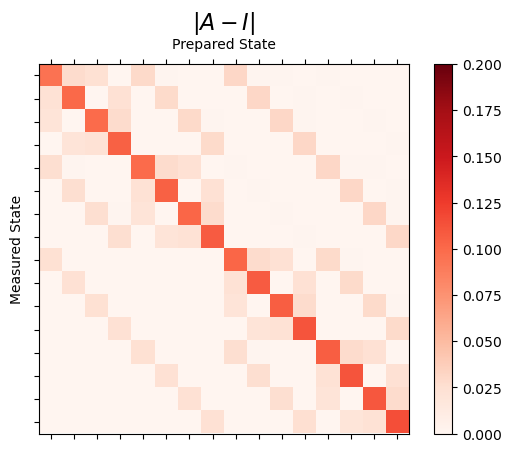

In [18]:
result.figure(0)